# Prepare

## import libraries

In [1]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline

## read data

In [2]:
ROOT = Path.cwd().parent
INPUT = ROOT / "input"
DATA = INPUT / "tabular-playground-series-mar-2021"
WORK = ROOT / "working"

for path in DATA.iterdir():
    print(path.name)

sample_submission.csv
train.csv
test.csv


In [3]:
train = pd.read_csv(DATA / "train.csv")
test = pd.read_csv(DATA / "test.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 32), test: (200000, 31), sample sub: (200000, 2)


In [4]:
train.head().T

,0,1,2,3,4
id,0,1,2,3,4
cat0,A,A,A,A,A
cat1,I,I,K,K,I
cat2,A,A,A,A,G
cat3,B,A,A,C,B
cat4,B,E,E,E,E
cat5,BI,BI,BI,BI,BI
cat6,A,K,A,A,C
cat7,S,W,E,Y,G
cat8,Q,AD,BM,AD,Q


# Prepocessing

In [5]:
## Print the categorical columns
print([c for c in train.columns if (1<train[c].nunique()) & (train[c].dtype != np.number)& (train[c].dtype != int) ])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  


['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']


In [6]:
cat_cols = [feature for feature in train.columns if 'cat' in feature]

def label_encoder(df):
    for feature in cat_cols:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

## Definition

In [7]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [8]:
cats = [ 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18']

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelEncoder, OrdinalEncoder


In [10]:
for col in cats:
    print(col)
    train_only = list(set(train[col].unique()) - set(test[col].unique()))
    test_only = list(set(test[col].unique()) - set(train[col].unique()))
    both = list(set(test[col].unique()).union(set(train[col].unique())))
    print(len(both), len(train_only), len(test_only))
    train.loc[train[col].isin(train_only), col] = np.nan
    test.loc[test[col].isin(test_only), col] = np.nan
    try:
        lbl = OrdinalEncoder(dtype='int')
        train[col] = lbl.fit_transform(train[col].astype('str').values.reshape(-1,1))
        train[col] = train[col].astype('category')
        test[col] = lbl.transform(test[col].astype('str').values.reshape(-1,1))
        test[col] = test[col].astype('category')
    except:
        try:
            lbl = LabelEncoder()
            fit_by = pd.Series([i for i in X[col].unique() if type(i) == str])
            lbl.fit(fit_by)
            train[col] = train[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
            test[col] = test[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
        except:
            drop_columns.append(col)

cat0
2 0 0
cat1
15 0 0
cat2
19 0 0
cat3
13 0 0
cat4
20 0 0
cat5
84 0 0
cat6
16 0 0
cat7
51 0 0
cat8
61 0 0
cat9
19 0 0
cat10
307 12 8
cat11
2 0 0
cat12
2 0 0
cat13
2 0 0
cat14
2 0 0
cat15
4 0 0
cat16
4 0 0
cat17
4 0 0
cat18
4 0 0


In [11]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [12]:
ID_COL = "id"
FEAT_COLS = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18','cont0','cont1','cont2','cont3',
             'cont4','cont5','cont6','cont7','cont8','cont9','cont10']
TGT_COL = "target"

N_SPLITS =10# 5
RANDOM_SEED =2021#999#422021,
USE_MODEL = "lgb"

MODEL_PARAMS = {
  
  "seed": RANDOM_SEED,
      "n_jobs": 4,
       'num_leaves': 250,
    'max_bin':550,
     'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.35,
    'bagging_fraction': 0.475,
    'min_data_in_leaf': 150,
     'max_depth': -1,
    'objective': 'binary',
    'learning_rate':  0.001867383057779643,
    "boosting_type": "gbdt",
    "metric": 'auc', 
     "bagging_seed": 7,
#"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
##'subsample': 0.8032697250789377, 
##'colsample_bytree': 0.21067140508531404, 
##'learning_rate': 0.009867383057779643,
## 'reg_lambda': 10.987474846877767, 
##            'reg_alpha': 17.335285595031994,     
      ##
'cat_smooth': 35,
 ## parameters to keep the exactly the same
'subsample_for_bin': 200000,
'min_child_samples':285, #20,    
    
    
    
    }
TRAIN_PARAMS = {
    "num_boost_round": 30000,
    "early_stopping_rounds": 100,
    "verbose_eval": 50,
}

## Prepare Data

In [13]:
X = train[FEAT_COLS]
X_test = test[FEAT_COLS]

y = train[TGT_COL].values

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
trn_val_indexs = list(kf.split(X, y))

## Training

In [14]:
oof_pred_arr = np.zeros(len(X))
test_preds_arr = np.zeros((N_SPLITS, len(X_test)))
feature_importances = pd.DataFrame()
score_list = []

In [15]:
for fold, (trn_idx, val_idx) in enumerate(trn_val_indexs):
    print("*" * 100)
    print(f"Fold: {fold}")

    X_trn = X.loc[trn_idx].reset_index(drop=True)
    X_val = X.loc[val_idx].reset_index(drop=True)
    y_trn = y[trn_idx]
    y_val = y[val_idx]

    model = TreeModel(model_type=USE_MODEL)
    with timer(prefix="Model training"):
        model.train(
            params=MODEL_PARAMS, X_train=X_trn, y_train=y_trn,
            X_val=X_val, y_val=y_val, train_params=TRAIN_PARAMS)
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_names_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    feature_importances = feature_importances.append(fi_tmp)

    val_pred = model.predict(X_val)
    score = roc_auc_score(y_val, val_pred)#, squared=False)

    print(f"score: {score:.5f}")
    score_list.append([fold, score])
    oof_pred_arr[val_idx] = val_pred
    test_pred = model.predict(X_test)
    test_preds_arr[fold] = test_pred

****************************************************************************************************
Fold: 0
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=285 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=285 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Info] Number of positive: 71363, number of negative: 198637
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6646
[LightGBM] [Info] Number of data points in the train set: 270000, number of used features: 30
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=285 will be ignored. Current value: min_data_in_leaf=150


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264307 -> initscore=-1.023700
[LightGBM] [Info] Start training from score -1.023700
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.89169	valid_1's auc: 0.885008
[100]	training's auc: 0.892461	valid_1's auc: 0.885798
[150]	training's auc: 0.893128	valid_1's auc: 0.886151
[200]	training's auc: 0.893706	valid_1's auc: 0.886466
[250]	training's auc: 0.89422	valid_1's auc: 0.886767
[300]	training's auc: 0.894716	valid_1's auc: 0.88701
[350]	training's auc: 0.895097	valid_1's auc: 0.88728
[400]	training's auc: 0.895584	valid_1's auc: 0.887542
[450]	training's auc: 0.896016	valid_1's auc: 0.887767
[500]	training's auc: 0.896478	valid_1's auc: 0.88804
[550]	training's auc: 0.896947	valid_1's auc: 0.88829
[600]	training's auc: 0.897389	valid_1's auc: 0.888528
[650]	training's auc: 0.89782	valid_1's auc: 0.888768
[700]	training's auc: 0.898236	valid_1's auc: 0.888967
[750]	training's auc: 0.89862	valid_1's au

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264830 -> initscore=-1.021016
[LightGBM] [Info] Start training from score -1.021016
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891694	valid_1's auc: 0.885151
[100]	training's auc: 0.892453	valid_1's auc: 0.885604
[150]	training's auc: 0.893092	valid_1's auc: 0.886247
[200]	training's auc: 0.89367	valid_1's auc: 0.886645
[250]	training's auc: 0.894203	valid_1's auc: 0.886962
[300]	training's auc: 0.894687	valid_1's auc: 0.887269
[350]	training's auc: 0.895078	valid_1's auc: 0.887455
[400]	training's auc: 0.895551	valid_1's auc: 0.887671
[450]	training's auc: 0.895994	valid_1's auc: 0.887894
[500]	training's auc: 0.896465	valid_1's auc: 0.888133
[550]	training's auc: 0.896942	valid_1's auc: 0.888367
[600]	training's auc: 0.897367	valid_1's auc: 0.888597
[650]	training's auc: 0.897797	valid_1's auc: 0.888807
[700]	training's auc: 0.898211	valid_1's auc: 0.889015
[750]	training's auc: 0.898601	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891627	valid_1's auc: 0.885284
[100]	training's auc: 0.892419	valid_1's auc: 0.885935
[150]	training's auc: 0.89309	valid_1's auc: 0.886403
[200]	training's auc: 0.893648	valid_1's auc: 0.886786
[250]	training's auc: 0.894169	valid_1's auc: 0.887138
[300]	training's auc: 0.894666	valid_1's auc: 0.88736
[350]	training's auc: 0.895052	valid_1's auc: 0.88758
[400]	training's auc: 0.895527	valid_1's auc: 0.887849
[450]	training's auc: 0.895959	valid_1's auc: 0.888094
[500]	training's auc: 0.89643	valid_1's auc: 0.888358
[550]	training's auc: 0.896901	valid_1's auc: 0.888586
[600]	training's auc: 0.897339	valid_1's auc: 0.888808
[650]	training's auc: 0.89777	valid_1's auc: 0.889006
[700]	training's auc: 0.898177	valid_1's auc: 0.889199
[750]	training's auc: 0.898555	valid_1's auc: 0.889383
[800]	training's auc: 0.899007	valid_1's auc: 0.889624
[850]	training's auc: 0.899436	valid_1's auc: 0.889847
[900]	tra

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891436	valid_1's auc: 0.886806
[100]	training's auc: 0.892225	valid_1's auc: 0.887243
[150]	training's auc: 0.892914	valid_1's auc: 0.887692
[200]	training's auc: 0.893493	valid_1's auc: 0.888023
[250]	training's auc: 0.89403	valid_1's auc: 0.888339
[300]	training's auc: 0.89455	valid_1's auc: 0.888629
[350]	training's auc: 0.894953	valid_1's auc: 0.888814
[400]	training's auc: 0.895444	valid_1's auc: 0.889053
[450]	training's auc: 0.895874	valid_1's auc: 0.88928
[500]	training's auc: 0.89635	valid_1's auc: 0.889519
[550]	training's auc: 0.896819	valid_1's auc: 0.889741
[600]	training's auc: 0.89726	valid_1's auc: 0.889951
[650]	training's auc: 0.897695	valid_1's auc: 0.89014
[700]	training's auc: 0.898112	valid_1's auc: 0.890335
[750]	training's auc: 0.898495	valid_1's auc: 0.890477
[800]	training's auc: 0.898948	valid_1's auc: 0.890658
[850]	training's auc: 0.899373	valid_1's auc: 0.890821
[900]	trai

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891434	valid_1's auc: 0.886636
[100]	training's auc: 0.892208	valid_1's auc: 0.88735
[150]	training's auc: 0.892868	valid_1's auc: 0.88782
[200]	training's auc: 0.89346	valid_1's auc: 0.888153
[250]	training's auc: 0.893985	valid_1's auc: 0.88852
[300]	training's auc: 0.894486	valid_1's auc: 0.888861
[350]	training's auc: 0.894875	valid_1's auc: 0.889123
[400]	training's auc: 0.895349	valid_1's auc: 0.889353
[450]	training's auc: 0.89579	valid_1's auc: 0.889608
[500]	training's auc: 0.896258	valid_1's auc: 0.889873
[550]	training's auc: 0.896735	valid_1's auc: 0.890146
[600]	training's auc: 0.897162	valid_1's auc: 0.89039
[650]	training's auc: 0.8976	valid_1's auc: 0.890609
[700]	training's auc: 0.898009	valid_1's auc: 0.890801
[750]	training's auc: 0.898391	valid_1's auc: 0.890978
[800]	training's auc: 0.898842	valid_1's auc: 0.891188
[850]	training's auc: 0.899268	valid_1's auc: 0.891389
[900]	traini

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891561	valid_1's auc: 0.885036
[100]	training's auc: 0.892303	valid_1's auc: 0.885618
[150]	training's auc: 0.892978	valid_1's auc: 0.886045
[200]	training's auc: 0.893552	valid_1's auc: 0.886507
[250]	training's auc: 0.894075	valid_1's auc: 0.88689
[300]	training's auc: 0.894566	valid_1's auc: 0.887146
[350]	training's auc: 0.89496	valid_1's auc: 0.887394
[400]	training's auc: 0.895435	valid_1's auc: 0.88764
[450]	training's auc: 0.895873	valid_1's auc: 0.887914
[500]	training's auc: 0.896348	valid_1's auc: 0.888192
[550]	training's auc: 0.896829	valid_1's auc: 0.88846
[600]	training's auc: 0.897271	valid_1's auc: 0.888721
[650]	training's auc: 0.897709	valid_1's auc: 0.888965
[700]	training's auc: 0.898125	valid_1's auc: 0.889162
[750]	training's auc: 0.898511	valid_1's auc: 0.889357
[800]	training's auc: 0.898969	valid_1's auc: 0.889577
[850]	training's auc: 0.899388	valid_1's auc: 0.889808
[900]	tr

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265081 -> initscore=-1.019722
[LightGBM] [Info] Start training from score -1.019722
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891222	valid_1's auc: 0.887897
[100]	training's auc: 0.891938	valid_1's auc: 0.888833
[150]	training's auc: 0.892634	valid_1's auc: 0.889262
[200]	training's auc: 0.893207	valid_1's auc: 0.889619
[250]	training's auc: 0.893743	valid_1's auc: 0.890054
[300]	training's auc: 0.894243	valid_1's auc: 0.890372
[350]	training's auc: 0.894632	valid_1's auc: 0.890639
[400]	training's auc: 0.89512	valid_1's auc: 0.890913
[450]	training's auc: 0.89556	valid_1's auc: 0.891109
[500]	training's auc: 0.896041	valid_1's auc: 0.891386
[550]	training's auc: 0.89652	valid_1's auc: 0.891648
[600]	training's auc: 0.896963	valid_1's auc: 0.891879
[650]	training's auc: 0.897402	valid_1's auc: 0.892079
[700]	training's auc: 0.897812	valid_1's auc: 0.89229
[750]	training's auc: 0.898192	valid_1'

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[binary:BoostFromScore]: pavg=0.264996 -> initscore=-1.020160
[LightGBM] [Info] Start training from score -1.020160
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891468	valid_1's auc: 0.886089
[100]	training's auc: 0.892265	valid_1's auc: 0.88698
[150]	training's auc: 0.892947	valid_1's auc: 0.887402
[200]	training's auc: 0.89351	valid_1's auc: 0.887787
[250]	training's auc: 0.894059	valid_1's auc: 0.888143
[300]	training's auc: 0.894561	valid_1's auc: 0.888416
[350]	training's auc: 0.894954	valid_1's auc: 0.888599
[400]	training's auc: 0.895424	valid_1's auc: 0.888912
[450]	training's auc: 0.895845	valid_1's auc: 0.889132
[500]	training's auc: 0.896315	valid_1's auc: 0.889378
[550]	training's auc: 0.896781	valid_1's auc: 0.889628
[600]	training's auc: 0.897216	valid_1's auc: 0.88987
[650]	training's auc: 0.897643	valid_1's auc: 0.890088
[700]	training's auc: 0.898058	valid_1's auc: 0.890297
[750]	training's auc: 0.898449	valid_1's auc: 0.890463
[

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.89149	valid_1's auc: 0.886987
[100]	training's auc: 0.892272	valid_1's auc: 0.887425
[150]	training's auc: 0.89299	valid_1's auc: 0.887941
[200]	training's auc: 0.893567	valid_1's auc: 0.888254
[250]	training's auc: 0.894093	valid_1's auc: 0.888599
[300]	training's auc: 0.894577	valid_1's auc: 0.888811
[350]	training's auc: 0.89497	valid_1's auc: 0.889003
[400]	training's auc: 0.895446	valid_1's auc: 0.889195
[450]	training's auc: 0.895875	valid_1's auc: 0.889415
[500]	training's auc: 0.896349	valid_1's auc: 0.889683
[550]	training's auc: 0.896833	valid_1's auc: 0.889925
[600]	training's auc: 0.897271	valid_1's auc: 0.89016
[650]	training's auc: 0.897702	valid_1's auc: 0.890356
[700]	training's auc: 0.89812	valid_1's auc: 0.890568
[750]	training's auc: 0.898506	valid_1's auc: 0.890722
[800]	training's auc: 0.89896	valid_1's auc: 0.89092
[850]	training's auc: 0.899386	valid_1's auc: 0.891127
[900]	train

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265352 -> initscore=-1.018335
[LightGBM] [Info] Start training from score -1.018335
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.891727	valid_1's auc: 0.883435
[100]	training's auc: 0.89249	valid_1's auc: 0.884075
[150]	training's auc: 0.893167	valid_1's auc: 0.884656
[200]	training's auc: 0.893767	valid_1's auc: 0.885019
[250]	training's auc: 0.89431	valid_1's auc: 0.885338
[300]	training's auc: 0.894807	valid_1's auc: 0.885627
[350]	training's auc: 0.895203	valid_1's auc: 0.885817
[400]	training's auc: 0.895682	valid_1's auc: 0.886108
[450]	training's auc: 0.896113	valid_1's auc: 0.886336
[500]	training's auc: 0.896588	valid_1's auc: 0.886589
[550]	training's auc: 0.897059	valid_1's auc: 0.886825
[600]	training's auc: 0.897504	valid_1's auc: 0.88706
[650]	training's auc: 0.897939	valid_1's auc: 0.887237
[700]	training's auc: 0.898339	valid_1's auc: 0.887416
[750]	training's auc: 0.898718	valid_1

## Check Result

### score of each fold and oof

In [16]:
oof_score = roc_auc_score(y, oof_pred_arr)#, squared=False)
score_list.append(["oof", oof_score])
pd.DataFrame(
    score_list, columns=["fold", "auc score"])

,fold,auc score
0,0,0.896084
1,1,0.896936
2,2,0.896400
3,3,0.897091
4,4,0.898541
5,5,0.897765
6,6,0.899238
7,7,0.897722
8,8,0.897966
9,9,0.895636


### feature importance

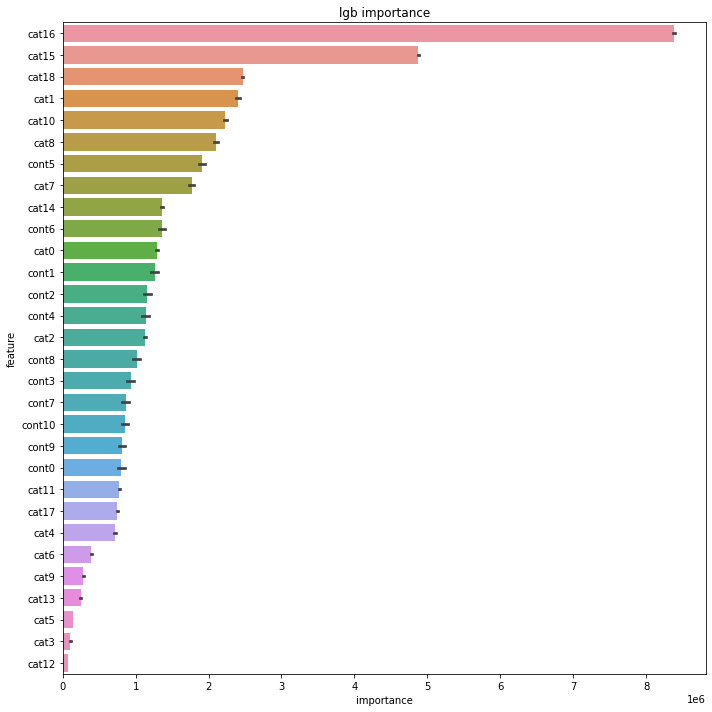

In [17]:
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format(USE_MODEL))
plt.tight_layout()

## Make submission

In [18]:
smpl_sub.head()

,id,target
0,5,0.5
1,6,0.5
2,8,0.5
3,9,0.5
4,11,0.5


In [19]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_preds_arr.mean(axis=0)

sub.to_csv("submission.csv", index=False)

sub.head()

,id,target
0,5,0.116484
1,6,0.372008
2,8,0.012850
3,9,0.217538
4,11,0.116358


In [20]:
np.save('train_oof', oof_pred_arr)
np.save('test_preds', test_preds_arr)

In [21]:
np.save('oof_preds.py',oof_pred_arr)
np.save('test_preds.py',test_preds_arr)

In [22]:
sub_best1 = pd.read_csv('../input/tps-mar-2021/submission_nn1.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best1.target * 0.9 + sub.target * 0.1
sub_final.to_csv('blend_mean11.csv', index=False)
sub_final.head()

,id,target
0,5,0.450673
1,6,0.739853
2,8,0.062060
3,9,0.587365
4,11,0.377660


In [23]:
sub_best11 = pd.read_csv('../input/tps-mar-2021/submission_nn1.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best11.target * 0.75 + sub.target * 0.25
sub_final.to_csv('blend_mean22.csv', index=False)
sub_final.head()

,id,target
0,5,0.394975
1,6,0.678546
2,8,0.053858
3,9,0.525727
4,11,0.334110


In [24]:
sub_best33 = pd.read_csv('../input/tps-mar-2021/submission_nn1.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best33.target * 0.8 + sub.target * 0.2
sub_final.to_csv('blend_mean22.csv', index=False)
sub_final.head()

,id,target
0,5,0.413541
1,6,0.698982
2,8,0.056592
3,9,0.546273
4,11,0.348626


In [25]:
sub_best2 = pd.read_csv('../input/tps-mar-2021/submission_nn2.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best2.target * 0.8 + sub.target * 0.2
sub_final.to_csv('blend_mean2.csv', index=False)
sub_final.head()

,id,target
0,5,0.424780
1,6,0.705176
2,8,0.121091
3,9,0.516873
4,11,0.369344


In [26]:
sub_best3 = pd.read_csv('../input/tps-mar-2021/submission_nn2.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best3.target * 0.75 + sub.target * 0.25
sub_final.to_csv('blend_mean3.csv', index=False)
sub_final.head()

,id,target
0,5,0.405512
1,6,0.684353
2,8,0.114326
3,9,0.498165
4,11,0.353532


In [27]:
sub_best4 = pd.read_csv('../input/tps-mar-2021/submission_nn2.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best4.target * 0.9 + sub.target * 0.1
sub_final.to_csv('blend_mean4.csv', index=False)
sub_final.head()

,id,target
0,5,0.463317
1,6,0.746822
2,8,0.134621
3,9,0.554290
4,11,0.400967


In [28]:
sub_best5 = pd.read_csv('../input/tps-mar-2021/submission_nn.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best5.target * 0.8 + sub.target * 0.2
sub_final.to_csv('blend_mean5.csv', index=False)
sub_final.head()

,id,target
0,5,6.829843
1,6,11.135228
2,8,1.070240
3,9,9.392952
4,11,6.588870


In [29]:
sub_best6 = pd.read_csv('../input/tps-mar-2021/submission_cv0.899063.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best6.target * 0.8 + sub.target * 0.2
sub_final.to_csv('blend_mean6.csv', index=False)
sub_final.head()

,id,target
0,5,0.413541
1,6,0.698982
2,8,0.056592
3,9,0.546273
4,11,0.348626


In [30]:
sub_best7 = pd.read_csv('../input/tps-mar-2021/submission_cv0.899063.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best7.target * 0.9 + sub.target * 0.1
sub_final.to_csv('blend_mean7.csv', index=False)
sub_final.head()

,id,target
0,5,0.450673
1,6,0.739853
2,8,0.062060
3,9,0.587365
4,11,0.377660


In [31]:
sub_best8 = pd.read_csv('../input/tps-mar-2021/submission 14.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best8.target * 0.9 + sub.target * 0.1
sub_final.to_csv('blend_mean8.csv', index=False)
sub_final.head()

,id,target
0,5,0.459266
1,6,0.729315
2,8,0.058802
3,9,0.597001
4,11,0.390633


In [32]:
sub_best9 = pd.read_csv('../input/tps-mar-2021/submission 14.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best9.target * 0.75 + sub.target * 0.25
sub_final.to_csv('blend_mean9.csv', index=False)
sub_final.head()

,id,target
0,5,0.402136
1,6,0.669764
2,8,0.051143
3,9,0.533757
4,11,0.344921


In [33]:
sub_best10 = pd.read_csv('../input/tps-mar-2021/submission 14.csv')
sub_final = sub.copy()
sub_final['target'] = sub_best10.target * 0.8 + sub.target * 0.2
sub_final.to_csv('blend_mean10.csv', index=False)
sub_final.head()

,id,target
0,5,0.421179
1,6,0.689614
2,8,0.053696
3,9,0.554839
4,11,0.360158
